In [1]:
!pip install fastai --upgrade -q

In [1]:
from fastai.vision.all import *

### Dataset preparation

In [3]:
dataset_url = 'https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz'

In [4]:
images_path = untar_data(dataset_url)

In [5]:
images_path.ls()

(#2) [Path('/root/.fastai/data/17flowers/files.txt'),Path('/root/.fastai/data/17flowers/files.txt~')]

In [2]:
classes = [
    "daffodil",
    "snowdrop",
    "lilyvalley",
    "bluebell",
    "crocus",
    "iris",
    "tigerlily",
    "tulip",
    "fritillary",
    "sunflower",
    "daisy",
    "coltsfoot",
    "dandelion",
    "cowslip",
    "buttercup",
    "windflower",
    "pansy",
]

In [3]:
len(classes)

17

In [8]:
image_names = sorted(list(images_path.rglob('*.jpg')))
image_names[:5]

[]

In [4]:
categories_num = len(classes)

In [2]:
path = Path('flowers-images-dataset')

In [11]:
# there are 80 images of each class, classes going one by one

images_per_class = 80

image_by_category = [image_names[images_per_class*i : images_per_class*i + images_per_class] for i in range(categories_num)]
image_by_category[:5]

[[], [], [], [], []]

In [12]:
path.mkdir(exist_ok=True)

for i, class_name in enumerate(classes):
    class_path = path/class_name
    class_path.mkdir(exist_ok=True)
    for image_path in image_by_category[i]:
        image_path.rename(class_path/image_path.name)

In [3]:
data = DataBlock((ImageBlock, CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=RandomSplitter(valid_pct=0.2, seed=42),                   
                  get_y=parent_label,
                  item_tfms=(Resize(350),ToTensor()),
                  batch_tfms=aug_transforms(size=224, min_scale=0.75, do_flip=True, flip_vert=True, max_rotate=50 )
                ) #parent_label) label_func

# datasets = data.datasets(images_path)

In [4]:
dataloaders = data.dataloaders(path, bs=64)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [5]:
dataloaders.vocab

['bluebell', 'buttercup', 'coltsfoot', 'cowslip', 'crocus', 'daffodil', 'daisy', 'dandelion', 'fritillary', 'iris', 'lilyvalley', 'pansy', 'snowdrop', 'sunflower', 'tigerlily', 'tulip', 'windflower']

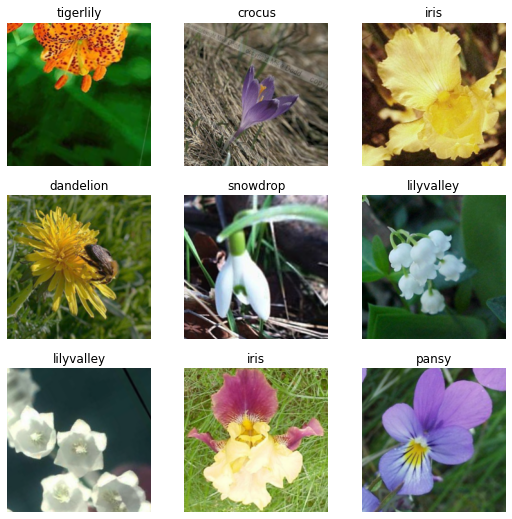

In [6]:
dataloaders.show_batch()

### Training

In [7]:
learn = cnn_learner(dataloaders, 
                    resnet50, 
                    metrics=accuracy, 
                    # loss_func=CrossEntropyLossFlat, 
                    # opt_func=Adam
                    )

SuggestedLRs(valley=0.0010000000474974513)

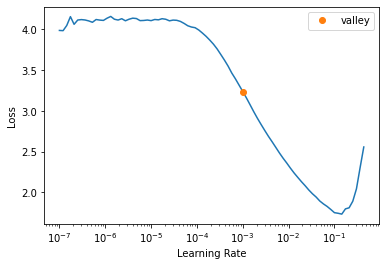

In [8]:
learn.lr_find()

In [9]:
lr = 1e-3

In [10]:
learn.fit_one_cycle(10, lr, cbs=[SaveModelCallback(monitor='valid_loss', every_epoch=True), 
                           ReduceLROnPlateau(patience=2)])

epoch,train_loss,valid_loss,accuracy,time
0,3.156800,0.962554,0.731618,00:28
1,1.707950,0.230267,0.930147,00:27
2,1.054938,0.190794,0.933824,00:26
3,0.715329,0.143476,0.952206,00:26
4,0.505587,0.103789,0.959559,00:26
5,0.380915,0.112941,0.959559,00:26
6,0.292847,0.096817,0.963235,00:26
7,0.221757,0.096370,0.966912,00:26
8,0.177494,0.091287,0.966912,00:26
9,0.142990,0.091195,0.966912,00:26


In [10]:
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                        

In [11]:
learn.unfreeze()

SuggestedLRs(valley=7.585775892948732e-05)

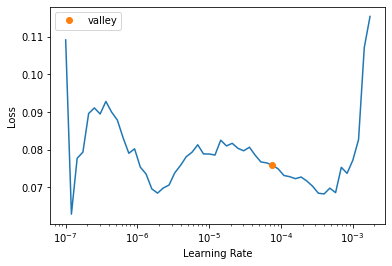

In [12]:
learn.lr_find()

In [13]:
lr=8e-5

In [14]:
learn.fit_one_cycle(6, lr, cbs=[SaveModelCallback(fname='model-stage2', monitor='valid_loss', every_epoch=True), 
                           ReduceLROnPlateau(patience=2)])

epoch,train_loss,valid_loss,accuracy,time
0,0.056016,0.067158,0.981618,00:33
1,0.057834,0.079470,0.974265,00:32
2,0.057114,0.059158,0.977941,00:32
3,0.055230,0.057480,0.974265,00:32
4,0.050103,0.048401,0.988971,00:32
5,0.048974,0.050200,0.992647,00:32


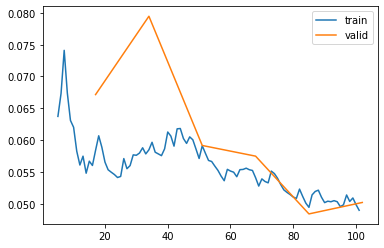

In [15]:
learn.recorder.plot_loss()


### Checking out results

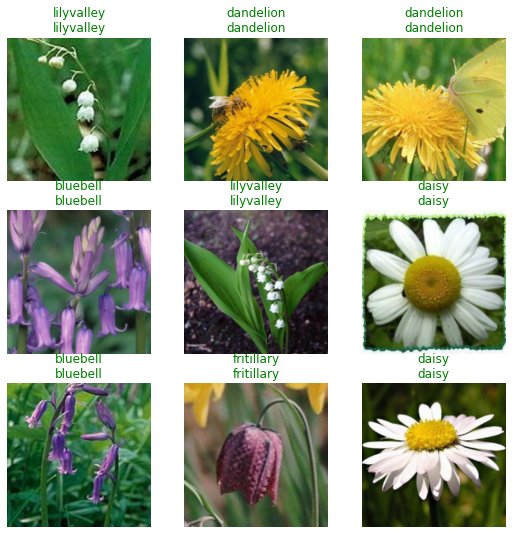

In [17]:
learn.show_results() #.show_results(ds_idx=1, nrows=3, figsize=(6,8))

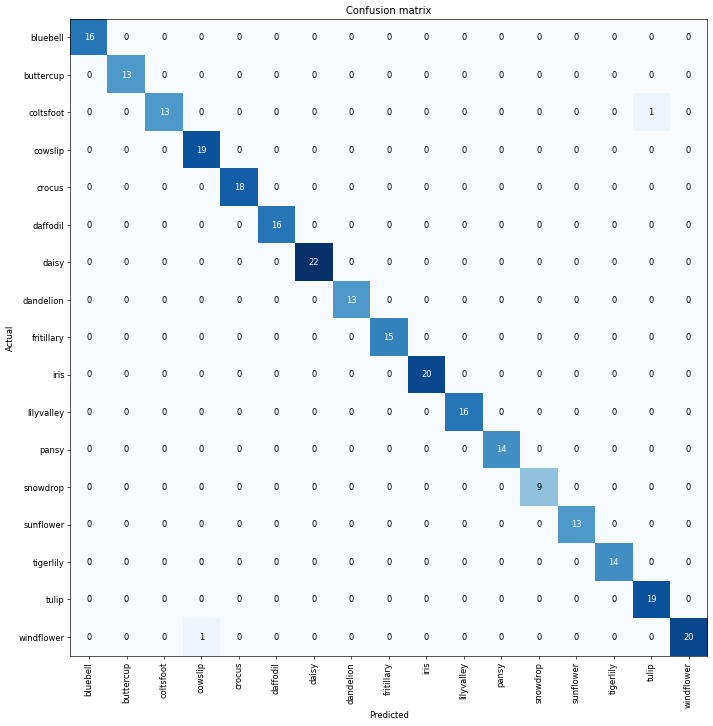

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [23]:
! wget -O image.jpg https://sciencepop.ru/wp-content/uploads/2017/06/narcissus-301546_960_720.jpg

--2022-02-20 18:27:44--  https://sciencepop.ru/wp-content/uploads/2017/06/narcissus-301546_960_720.jpg
Resolving sciencepop.ru (sciencepop.ru)... 87.236.16.243
Connecting to sciencepop.ru (sciencepop.ru)|87.236.16.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67568 (66K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  65.98K  --.-KB/s    in 0.04s   

2022-02-20 18:27:44 (1.47 MB/s) - ‘image.jpg’ saved [67568/67568]



In [ ]:
PIL.Image.open('image.jpg')

In [26]:
%%time 

learn.predict('image.jpg')

CPU times: user 175 ms, sys: 321 ms, total: 495 ms
Wall time: 1.24 s


('daffodil',
 TensorBase(5),
 TensorBase([2.0652e-04, 1.1737e-02, 3.3745e-04, 1.9489e-02, 9.0564e-05, 7.9653e-01,
         4.3763e-03, 1.9912e-04, 1.4468e-03, 2.1952e-07, 2.3836e-04, 2.3397e-02,
         1.5105e-03, 4.3987e-03, 5.3700e-02, 7.5469e-02, 6.8692e-03]))

In [27]:
! pip freeze 

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.5.2
chardet==3.0.4
charset-normalizer==2.0.11
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.27
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill=